<a href="https://colab.research.google.com/github/GURJEW/tasks/blob/main/BFGS_vs_SGD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [ ]:
import numpy as np
from numpy.random import choice, randint
from numpy.linalg import norm
import pandas as pd
import seaborn as sns
sns.set(palette="pastel", color_codes=True)
from seaborn import distplot, lmplot, boxplot, violinplot
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris, load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import line_search, BFGS, minimize

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

from IPython.display import clear_output
from time import time
from google.colab import drive
import os

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/Colab Notebooks/MATH/deep_math')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


#Обучение

In [ ]:
class Model():
    def __init__(
        self,
        input_dim,
        hidden_dim,
        output_dim,
        data=None,
        bias=True,
        init_high=0.05,
        regularization=False
        ):
        self.input_dim = input_dim + bias
        self.hidden_dim = hidden_dim + bias
        self.output_dim = output_dim
        self.bias = bias
        self.history = {
            'train_loss': [], 'val_loss': [],
            'train_accuracy': [], 'val_accuracy': []
            }
        self.weights = np.random.uniform(
                low=0,
                high=init_high,
                size=(self.hidden_dim * self.input_dim + self.output_dim * self.hidden_dim)
                )
        self.inputs = None
        self.outputs = None
        self.test_loss = None
        self.test_accuracy = None
        self.fit_time = None


    def add_bias(self, x):
        if x.ndim == 1:
            x = x[np.newaxis, ...]
        if self.bias:
            return np.hstack([np.ones((len(x), 1)), x])
        else:
            return x


    def concatenate_layers(self, hidden, output):
        return np.concatenate((hidden.flatten(), output.flatten()))


    def split_layers(self, flattened):
        hidden, output = np.split(flattened, [self.hidden_dim * self.input_dim])
        return hidden.reshape((self.hidden_dim, self.input_dim)), \
                output.reshape((self.output_dim, self.hidden_dim))


    def activate(self, x):
        return 1 / (1 + np.exp(x))


    def derivate(self, x):
        return self.activate(x) * (1 - self.activate(x))


    def layer_forward(self, inputs, weights):
        states = inputs @ weights.T
        return states, self.activate(states)


    def forward(self, weights):
        hidden_waights, output_weights = self.split_layers(weights)
        hidden_states, hidden_activates = self.layer_forward(self.inputs, hidden_waights)
        output_states, output_activates = self.layer_forward(hidden_activates, output_weights)
        return hidden_states, hidden_activates, output_states, output_activates


    def get_loss(self, weights):
        return self.mse(self.outputs, self.forward(weights)[-1])


    def get_gradients(self, weights):
        hidden_states, hidden_activates, output_states, output_activates = self.forward(weights)
        deltas = (self.outputs - output_activates) * self.derivate(output_states)
        output_gradient = deltas.T @ hidden_activates
        errors = - deltas @ self.split_layers(weights)[1]
        deltas = errors * self.derivate(hidden_states)
        hidden_gradient = deltas.T @ self.inputs
        return self.concatenate_layers(hidden_gradient, output_gradient)


    def mse(self, d, y):
        return ((d - y) ** 2).mean()


    def accuracy(self, d, y):
        return np.equal(d.argmax(1), y.argmax(1)).mean()


    def smooth(self, metric, lambda_, subset):
        if self.history[subset]:
            quality = self.history[subset][-1]
        else:
            quality = metric
        return (1 - lambda_) * quality + metric * lambda_


    def predict(self, x, add_bias=True):
        if add_bias:
            self.inputs = self.add_bias(x)
        else:
            self.inputs = x
        return self.forward(self.weights)[-1]


    def evaluate(self, x, y, add_bias=True):
        y_pred = self.predict(x, add_bias)
        return round(self.mse(y, y_pred), 4), round(self.accuracy(y, y_pred), 4)


    def plot_history(self, metric):
        plt.figure(figsize=(8, 4))
        plt.plot(self.history[f'train_{metric}'], label=f'train_{metric}')
        plt.plot(self.history[f'val_{metric}'], label=f'val_{metric}')
        plt.legend()
        plt.xlabel('epoch')
        plt.ylabel(metric)
        plt.grid(True)
        plt.show()


    def clear_and_plot(self):
        clear_output()
        self.plot_history('loss')
        self.plot_history('accuracy')
        print('train_loss:\t ', round(self.history['train_loss'][-1], 4))
        print('train_accuracy:\t ', round(self.history['train_accuracy'][-1], 4))
        print('val_loss:\t ', round(self.history['val_loss'][-1], 4))
        print('val_accuracy:\t ', round(self.history['val_accuracy'][-1], 4))


    def get_metrics(self, subset, lambda_):
        loss, accuracy = self.evaluate(self.inputs, self.outputs, False)
        return self.smooth(loss, lambda_, f'{subset}_loss'), self.smooth(accuracy, lambda_, f'{subset}_accuracy')


    def validate(self, x_val, y_val, lambda_):
        train_loss, train_accuracy = self.get_metrics('train', lambda_)
        self.inputs = x_val
        self.outputs = y_val
        val_loss, val_accuracy = self.get_metrics('val', lambda_)
        for metric in self.history.keys():
            self.history[metric].append(eval(metric))


    def get_sizes(self, x, validation_split):
        x_size = len(x)
        val_size = int(x_size * validation_split)
        return x_size, x_size - val_size, val_size


    def SGD(self,x, y, epochs, batch_size, validation_split=0.2,
            learning_rate=0.01, lambda_=0.1, patience=5, **kwargs):
        x = self.add_bias(x)
        x_size, train_size, val_size = self.get_sizes(x, validation_split)
        for epoch in range(epochs):
            shuffle = choice(x_size, x_size, replace=False)
            for batch in range(0, train_size, batch_size):
                indeces = shuffle[batch:batch+batch_size]
                self.inputs = x[indeces]
                self.outputs = y[indeces]
                gradients = self.get_gradients(self.weights)
                self.weights -= learning_rate * gradients
            indeces = shuffle[-val_size:]
            self.validate(x[indeces], y[indeces], lambda_)
            if not (epoch + 1) % 50:
                self.clear_and_plot()
            if epoch > patience and \
                self.history['val_loss'][-patience-1] <= min(self.history['val_loss'][-patience:]):
                break


    def get_H(self, H, I):
        gradients = self.get_gradients(self.weights)
        direction_point = - H @ gradients
        alpha = line_search(self.get_loss, self.get_gradients, self.weights, direction_point)[0]                
        if not alpha:
            print('ALPHA IS NONE!')
            return H
        else:            
            diff_weights = alpha * direction_point
            self.weights += diff_weights
            new_gradients = self.get_gradients(self.weights)
            diff_gradients = new_gradients - gradients
            gradients = new_gradients
            ro = 1.0 / (diff_gradients @ diff_weights)
            A1 = I - ro * diff_weights[:, np.newaxis] * diff_gradients[np.newaxis, :]
            A2 = I - ro * diff_gradients[:, np.newaxis] * diff_weights[np.newaxis, :]
            return (A1 @ (H @ A2)) + (ro * diff_weights[:, np.newaxis] * diff_weights[np.newaxis, :])


    def BFGS(self, x, y, epochs, validation_split=0.2, lambda_=0.1, patience=5, **kwargs):
        x_train, x_val, y_train, y_val = train_test_split(self.add_bias(x), y, test_size=validation_split)
        H = np.eye(self.weights.size) 
        I = np.eye(self.weights.size)
        for epoch in range(epochs):
            self.inputs = x_train
            self.outputs = y_train
            H = self.get_H(H, I)
            self.validate(x_val, y_val, lambda_)
            if not epoch % 10:
                self.clear_and_plot()
            if epoch > patience and self.history['val_loss'][-patience-1] <= min(self.history['val_loss'][-patience:]):
                break


    def SBFGS(self, x, y, epochs, batch_size, validation_split=0.2, lambda_=0.1, patience=5, **kwargs):
        x = self.add_bias(x)
        x_size, train_size, val_size = self.get_sizes(x, validation_split)
        H = np.eye(self.weights.size) 
        I = np.eye(self.weights.size)        
        for epoch in range(epochs):
            shuffle = choice(x_size, x_size, replace=False)
            for batch in range(0, train_size, batch_size):
                indeces = shuffle[batch:batch+batch_size]
                self.inputs = x[indeces]
                self.outputs = y[indeces]
                H = self.get_H(H, I)            
            indeces = shuffle[-val_size:]
            self.validate(x[indeces], y[indeces], lambda_)
            if not epoch % 10:
                self.clear_and_plot()
            if epoch > patience and self.history['val_loss'][-patience-1] <= min(self.history['val_loss'][-patience:]):
                break


    def fit(self, method, test=None, **kwargs):
        start_time = time()
        if method == 'SGD':
            self.SGD(**kwargs)
        elif method == 'BFGS':
            self.BFGS(**kwargs)
        elif method == 'SBFGS':
            self.SBFGS(**kwargs)
        self.fit_time = time() - start_time
        self.clear_and_plot()
        if test:
            self.test_loss, self.test_accuracy = self.evaluate(*test)
            print('test_loss:\t ', round(self.test_loss, 4))
            print('test_accuracy:\t ', round(self.test_accuracy, 4))
        

    def to_log(self, model_params, fit_params, new_log=False):

        def get_columns():
            return list(model_params.keys()) + list(fit_params.keys()) + list(self.history.keys()) \
                  + ['test_loss', 'test_accuracy', 'last_epoch', 'fit_time']

        if new_log:
            log = pd.DataFrame(columns=get_columns())
        else:    
            try:
                log = pd.read_csv('bfgs_log.csv', index_col=0)
            except:
                log = pd.DataFrame(columns=get_columns())

        record = {item[0]: item[1][-1] for item in self.history.items()}
        record.update(model_params)
        record.update(fit_params)
        record['test_loss'] = self.test_loss
        record['test_accuracy'] = self.test_accuracy
        record['last_epoch'] = len(self.history['train_loss'])
        record['fit_time'] = round(self.fit_time, 2)
        log.loc[len(log)] = record
        log.to_csv('bfgs_log.csv')

##SGD

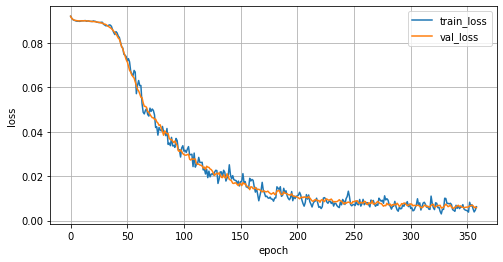

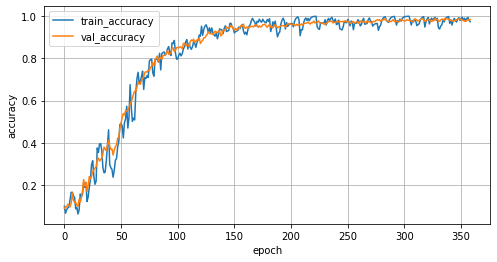

train_loss:	  0.0062
train_accuracy:	  0.9737
val_loss:	  0.0058
val_accuracy:	  0.9847
test_loss:	  0.0069
test_accuracy:	  0.9778


In [ ]:
digits = load_digits()

x = digits.data 

y = np.zeros((len(digits.target), len(digits.target_names)))
for i in range(y.shape[-1]):
    y[digits.target == i, i] = 1

x_train, x_test, y_train, y_test = train_test_split(
    MinMaxScaler().fit_transform(x), y, test_size=0.2
    )

model_params = {
    'data': 'DIGIT',
    'input_dim': x_train.shape[-1],
    'hidden_dim': 20,
    'output_dim': y_train.shape[-1],
    'bias': True,
    'init_high': 0.1
}

fit_params = {
    'method': 'SGD',
    'epochs': 1000,
    'batch_size': 30,
    'learning_rate': 0.01,
    'lambda_': 0.5,
    'patience': 20
}

for _ in range(10):
    model = Model(**model_params)
    model.fit(x=x_train, y=y_train, test=[x_test, y_test], **fit_params)
    model.to_log(model_params, fit_params)

##BFGS

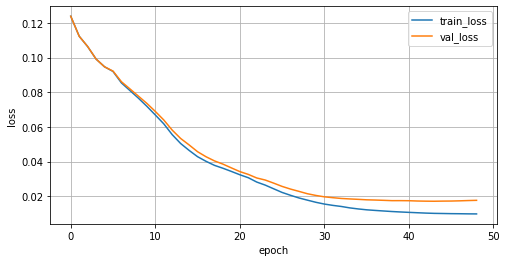

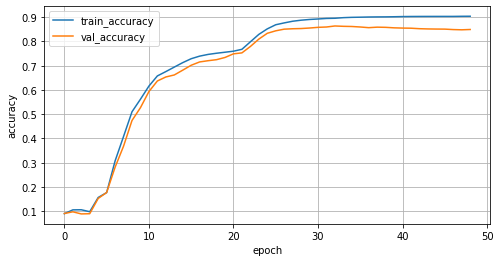

train_loss:	  0.0098
train_accuracy:	  0.9041
val_loss:	  0.0177
val_accuracy:	  0.8494
test_loss:	  0.018
test_accuracy:	  0.85


In [ ]:
digits = load_digits()

x = digits.data 

y = np.zeros((len(digits.target), len(digits.target_names)))
for i in range(y.shape[-1]):
    y[digits.target == i, i] = 1

x_train, x_test, y_train, y_test = train_test_split(
    MinMaxScaler().fit_transform(x), y, test_size=0.2
    )

model_params = {
    'data': 'DIGIT',
    'input_dim': x_train.shape[-1],
    'hidden_dim': 20,
    'output_dim': y_train.shape[-1],
    'bias': True,
    'init_high': 0.1
}

fit_params = {
    'method': 'BFGS',
    'epochs': 100,
    'batch_size': None,
    'learning_rate': None,
    'lambda_': 0.5,
    'patience': 5
}

for _ in range(10):
    model = Model(**model_params)
    model.fit(x=x_train, y=y_train, test=[x_test, y_test], **fit_params)
    model.to_log(model_params, fit_params)

##SBFGS

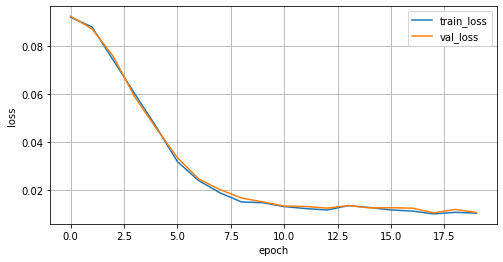

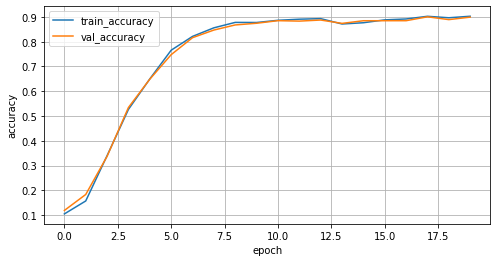

train_loss:	  0.0106
train_accuracy:	  0.903
val_loss:	  0.0109
val_accuracy:	  0.8994
test_loss:	  0.0176
test_accuracy:	  0.8556


In [ ]:
digits = load_digits()

x = digits.data 

y = np.zeros((len(digits.target), len(digits.target_names)))
for i in range(y.shape[-1]):
    y[digits.target == i, i] = 1

x_train, x_test, y_train, y_test = train_test_split(
    MinMaxScaler().fit_transform(x), y, test_size=0.2
    )

model_params = {
    'data': 'DIGIT',
    'input_dim': x_train.shape[-1],
    'hidden_dim': 20,
    'output_dim': y_train.shape[-1],
    'bias': True,
    'init_high': 0.1
}

fit_params = {
    'method': 'SBFGS',
    'epochs': 20,
    'batch_size': 220,
    'learning_rate': None,
    'lambda_': 0.5,
    'patience': 5
}

for _ in range(10):
    model = Model(**model_params)
    model.fit(x=x_train, y=y_train, test=[x_test, y_test], **fit_params)
    model.to_log(model_params, fit_params)

#Результаты

In [ ]:
def plot_boxes(data, groupby):
    data = data.sort_values(by=groupby)
    fig, ax = plt.subplots(3, 2, figsize=(20, 20))
    for row, subset in enumerate(['train', 'val', 'test']):
        for col, metric in enumerate(['loss', 'accuracy']):
            stats = data.groupby(groupby).agg({f'{subset}_{metric}': ['min', 'max']}).round(4)
            for i, kind in enumerate(data[groupby].unique()):
                for stat in stats[f'{subset}_{metric}'].columns:
                    value = stats[f'{subset}_{metric}'].loc[kind, stat]
                    ax[row, col].text(i + 0.25, value, value)
            boxplot(x=groupby, y=f'{subset}_{metric}', data=data, ax=ax[row, col], fliersize=3, width=0.4)
    plt.show()

In [ ]:
log = pd.read_csv('bfgs_log.csv', index_col=0)
log

,data,input_dim,hidden_dim,output_dim,bias,init_high,method,epochs,batch_size,learning_rate,lambda_,patience,train_loss,val_loss,train_accuracy,val_accuracy,test_loss,test_accuracy,last_epoch,fit_time
0,DIGIT,64,20,10,True,0.1,SGD,1000,220.0,0.01,0.5,20,0.005394,0.005657,0.987672,0.981220,0.0063,0.9750,326,4.91
1,DIGIT,64,20,10,True,0.1,SGD,1000,220.0,0.01,0.5,20,0.006205,0.006183,0.979628,0.981193,0.0072,0.9750,296,4.53
2,DIGIT,64,20,10,True,0.1,SGD,1000,220.0,0.01,0.5,20,0.006272,0.006068,0.977599,0.983138,0.0074,0.9694,293,4.29
3,DIGIT,64,20,10,True,0.1,SGD,1000,220.0,0.01,0.5,20,0.006501,0.006168,0.981634,0.982446,0.0072,0.9722,277,4.26
4,DIGIT,64,20,10,True,0.1,SGD,1000,220.0,0.01,0.5,20,0.007021,0.007058,0.980639,0.976781,0.0076,0.9694,291,4.25
5,DIGIT,64,20,10,True,0.1,SGD,1000,220.0,0.01,0.5,20,0.006702,0.008182,0.982746,0.975224,0.0080,0.9694,260,4.12
6,DIGIT,64,20,10,True,0.1,SGD,1000,220.0,0.01,0.5,20,0.005233,0.005542,0.983078,0.980880,0.0070,0.9750,316,4.84
7,DIGIT,64,20,10,True,0.1,SGD,1000,220.0,0.01,0.5,20,0.005840,0.006051,0.978587,0.980771,0.0068,0.9750,308,4.71
8,DIGIT,64,20,10,True,0.1,SGD,1000,220.0,0.01,0.5,20,0.005725,0.005450,0.984332,0.981730,0.0070,0.9750,321,5.06
9,DIGIT,64,20,10,True,0.1,SGD,1000,220.0,0.01,0.5,20,0.009709,0.009523,0.951042,0.955761,0.0095,0.9778,211,3.26


In [ ]:
log.loc[log.method == 'SGD', 'batch_size'].value_counts()

30.0     10
220.0    10
Name: batch_size, dtype: int64

In [ ]:
log.loc[log.method == 'SBFGS', 'batch_size'].value_counts()

1437.0    10
220.0     10
Name: batch_size, dtype: int64

##Сравнение алгоритмов

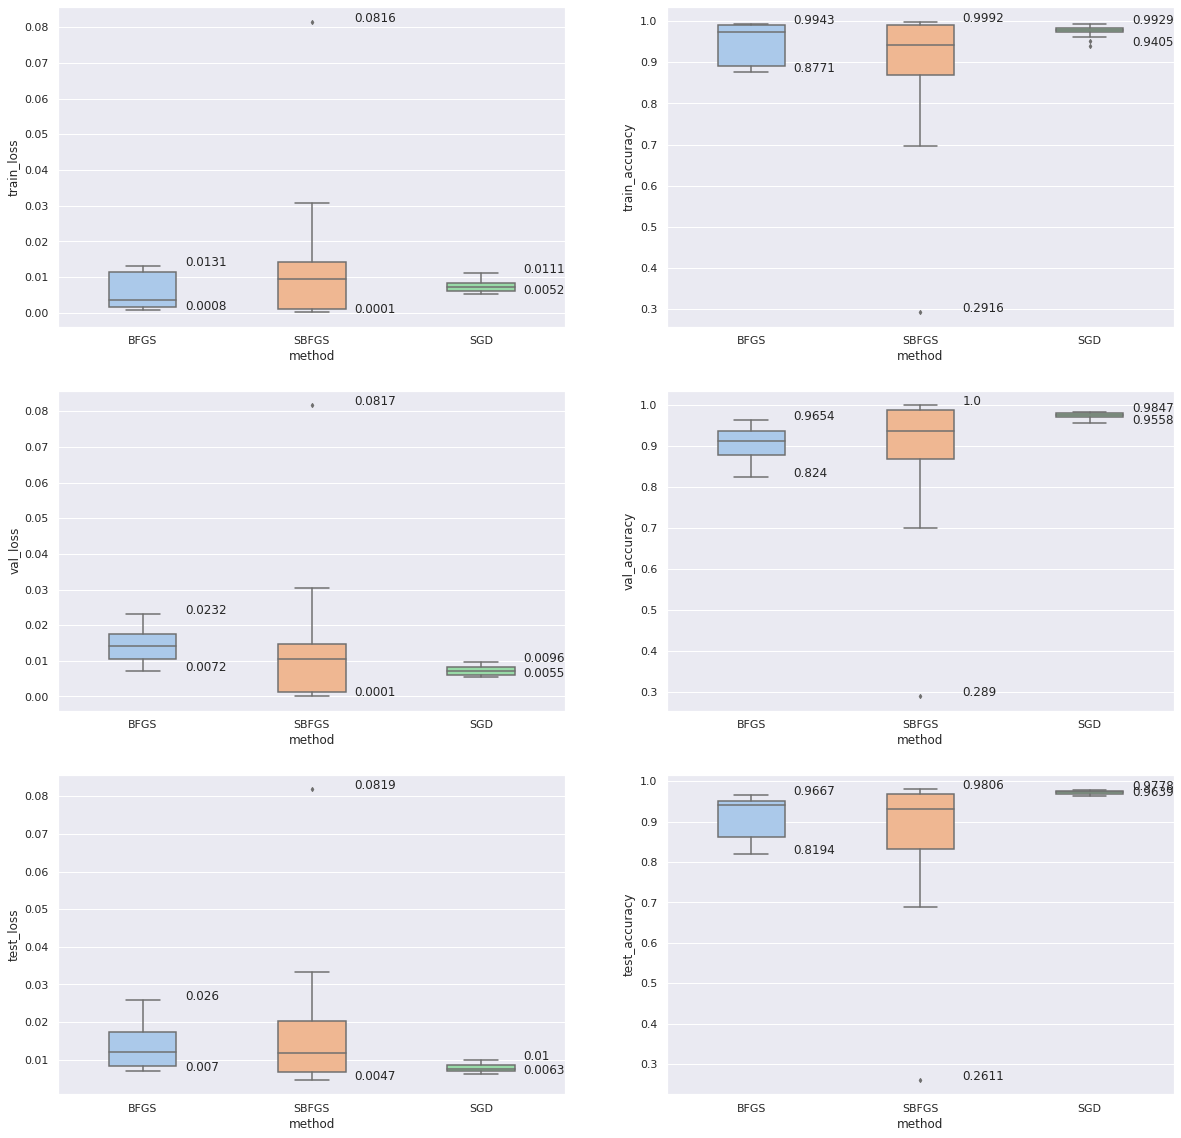

In [ ]:
plot_boxes(log, 'method')

##Перекрёстная валидация при BFGS

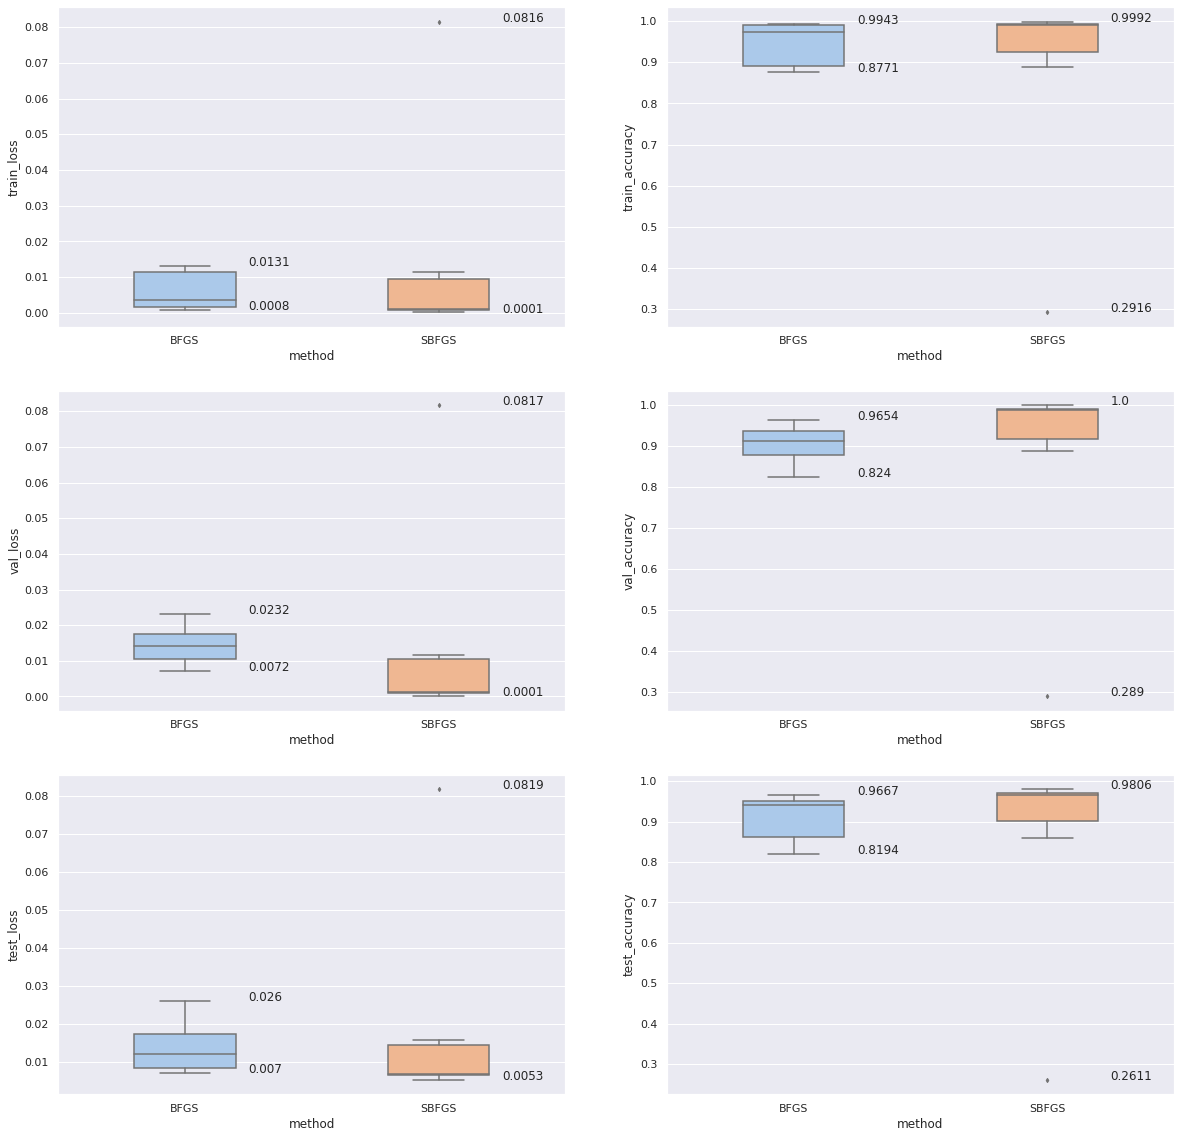

In [ ]:
plot_boxes(log.loc[(log.method == 'BFGS') | (log.batch_size == log.batch_size.max())], 'method')

##Размер пакета SGD

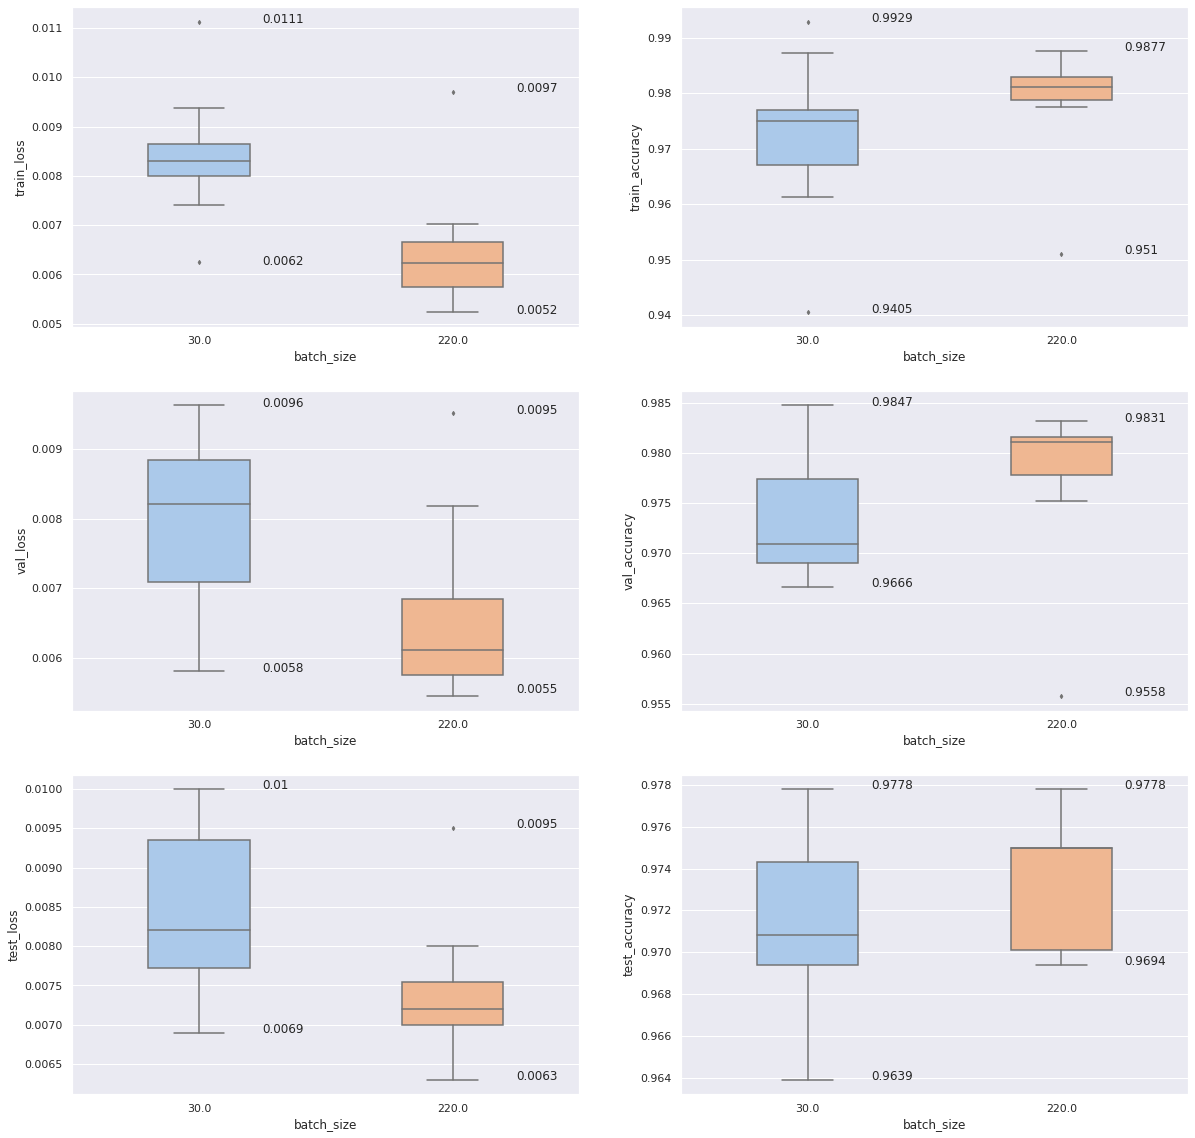

In [ ]:
plot_boxes(log.loc[log.method == 'SGD'], 'batch_size')

##Размер пакета SBFGS

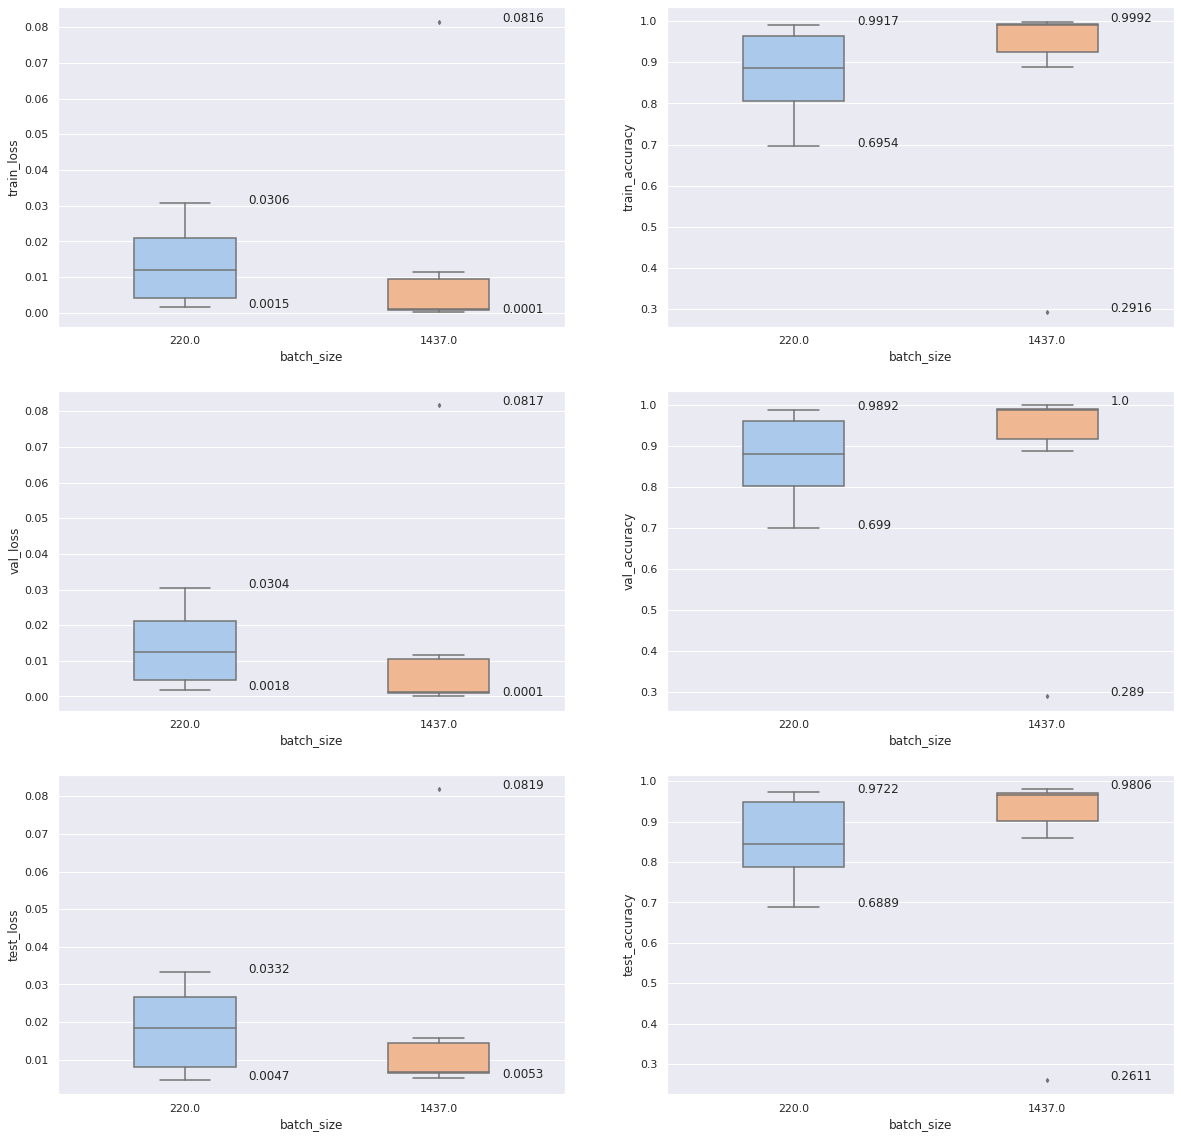

In [ ]:
plot_boxes(log.loc[log.method == 'SBFGS'], 'batch_size')

##Среднее количество эпох и время обучения

In [ ]:
log.fillna(log.batch_size.max()).groupby(['method', 'batch_size']).agg({'last_epoch': 'mean', 'fit_time': 'mean'}).round()

last_epoch  fit_time
method batch_size                      
BFGS   1437.0            54.0      31.0
SBFGS  220.0             20.0      62.0
       1437.0            53.0      30.0
SGD    30.0             274.0       5.0
       220.0            290.0       4.0

#Выводы


1.   SGD даёт меньшую дисперсию и большую среднюю точность в сравнении с методами BFGS.
2.   При многократных запусках с помощью алгоритма BFGS можно добиться более высокой точности, чем с помощью SGD.
3.   Перекрёстная валидация повышает точность BFGS и предотвращает переобучение.
4.   Пакетное обучение методом SBFGS занимает в два раза больше времени и в два раза меньше эпох, чем обучение BFGS на всём датасете сразу.
5.   При обучении методом BFGS возможна ситуация, когда линейный поиск не сходится (особенно при пакетном обучении).
6.   Обучение методом BFGS занимает больше времени, но меньше эпох, чем методом SGD.





#EOF